# Ejercicios tema 2

In [ ]:
import pandas as pd 

def si_formatter(x):
    return r"$\SI{{{:.2e}}}{{}}$".format(x)

def export_dataframe_to_tex(df, headers,filename="output.tex",captions="",labels=""):
    """
    Exporta un DataFrame a LaTeX con \toprule y \bottomrule,
    sin encabezados ni índices. El header se añade a mano en el .tex.
    """
    latex_str = df.to_latex(
        buf=None,
        header=True,              # No encabezados automáticos
        index=False,               # No índices
        #na_rep="NaN",              
        float_format=si_formatter,
        column_format="c" * (df.shape[1]+10),  # Número de columnas según DataFrame
        longtable=False,           # Evita bloques firsthead/lastfoot
        escape=False,              # Permitir LaTeX en celdas
        multicolumn=False,
        multirow=False,
        caption=captions,
        label=labels,
        #siunitx=True
    )
    
    with open(filename, "w", encoding="utf-8") as f:
        f.write(latex_str)

    print(f"Archivo LaTeX generado: {filename}")



## Ejercicio 3

Básicamente tenemos que calcular $\Delta p_{\min}$, $\Delta p_{\max}$, $\Delta E_{\min}$ y $\Delta E_{\min}$ para los $Z$ que nos presentan. Las ecuaciones que hemos usado son 

In [ ]:
import numpy as np
import matplotlib.pyplot as plt 
import scipy.constants as cte
from scipy.constants import physical_constants

###############################

re = physical_constants["classical electron radius"][0]  # valor numérico en metros
re_fm = re*10**(12)
me_MeV=cte.m_e*cte.c**2/cte.e/10**6
mp_MeV=cte.m_p*cte.c**2/cte.e/10**6
mn_MeV=cte.m_n*cte.c**2/cte.e/10**6

def p(m,E):
    """ Momento clásico

    Args:
        m (real): masa
        E (real): energía cinética

    Returns:
        momento: momento de la partícula para una masa y energía cinética
    """
    return np.sqrt(2*m*E)


def v(p,m):
    v = p/m*cte.c
    return v

def beta(v):
    beta=v/cte.c
    return beta

def DEmax(Ek,m1,m2):
    """ Trasferencia máxima de energía cinética no relativista

    Args:
        Ek (real): energía cinética
        m1 (real): masa incidente
        m2 (real): masa blanco

    Returns:
        DEmax: energía cinética máxima transferida
    """
    factor = 4*m1*m2/(m1**2+m2**2+2*m1*m2)    
    return factor*Ek

def b(Z,E,beta):
    """ Parámetro de impacto (en fentometros)

    Args:
        Z (carga del núcleo incidente): carga del núcleo incidente
        E (real): energía transferida 
        beta (real): velocidad de la partícula (en c)

    Returns:
        b: parámetro de impacto
    """
    b = Z*re_fm*beta/(E/2*me_MeV)
    return b

###############################

header = np.array(["","H","Al","Cu","Ag","Au","Tl","Pb"])
index = np.array(["Z","I [eV]","m [MeV/c$^2$]","$\\Delta E_{\\max}$ [MeV]","$\\Delta p_{\\max}$ [MeV/c]","$\\Delta E_{\\min}$ [eV]","$\\Delta p_{\\min}$ [MeV/c]","$b_{\\max}$ [fm]","$b_{\\min}$ [fm]"])
Z=np.array([1,13,29,47,79,81,82])
I=np.array([19,166,322,470,790,727,823])
M=cte.m_u*cte.c**2/10**6/cte.e*np.array([1,	26,98,63.546,107.87,196.96,204.38,207.2])
Ek=10 # MeV

beta_data=beta(v(p(mp_MeV,Ek),mp_MeV))
print("beta=",beta_data)
print("v=",beta_data*cte.c)
print("p=",p(mp_MeV,Ek))
################################
data = np.zeros((9,8),dtype=object)
data[:,0] = index 
#data[0,1:] = header 
data[0,1:] = Z 
data[1,1:] = I
data[2,1:] = M  
data[3,1:] = DEmax(Ek,mp_MeV,me_MeV)
data[4,1:] = p(mp_MeV,DEmax(Ek,mp_MeV,me_MeV))
data[5,1:] = I
data[6,1:] = p(mp_MeV,I*10**(-6))
data[7,1:] = b(Z,I*10**(-6),beta_data)
data[8,1:] = b(Z,data[4,1:],beta_data)

df = pd.DataFrame(
    data=data[:, :],         # todas las filas excepto la cabecera
    columns=header       # primera fila = header
)
export_dataframe_to_tex(df,header,"02-03.tex",labels="Tab:02-ex03",captions="resultados del ejercicio.")

beta= 0.14599924132329115
v= 43769471.42244463
p= 136.98701321134476
Archivo LaTeX generado: 02-03.tex


## Ejercicio 4

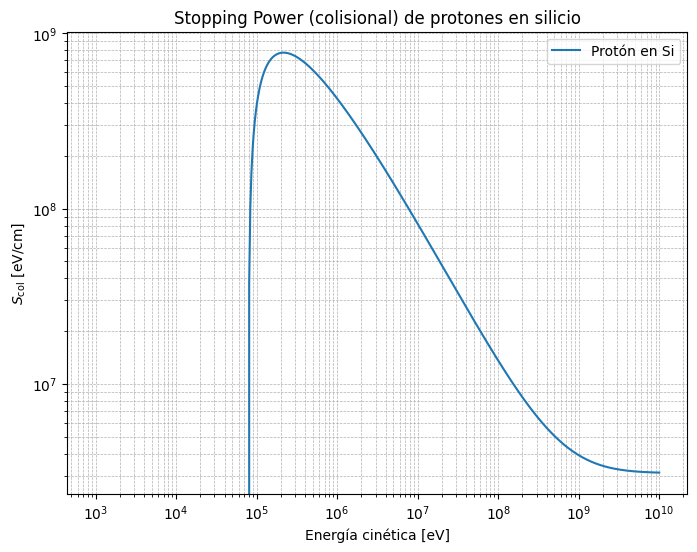

In [117]:
import numpy as np
import matplotlib.pyplot as plt
import math

# Constantes físicas (SI)
pi    = math.pi
e     = 1.602176634e-19      # C
eps0  = 8.8541878128e-12     # F/m
me    = 9.1093837015e-31     # kg
c     = 299792458.0          # m/s
eV    = 1.602176634e-19      # J

# Masa del protón
mp = 1.67262192369e-27  # kg

def beta2_from_E(E, M, relativistic=True):
    if relativistic:
        gamma = 1.0 + E/(M*c*c)
        if gamma <= 1.0:
            return 0.0
        return 1.0 - 1.0/(gamma*gamma)
    return max(0.0, 2.0*E/(M*c*c))

def S_col(E, z, N_e, I, M, relativistic=True):
    beta2 = beta2_from_E(E, M, relativistic=relativistic)
    if beta2 <= 0.0:
        return 0.0

    pref = 4.0*pi*N_e * (e*e/(4.0*pi*eps0))**2
    term = (z*z)/(me*c*c*beta2)
    arg = 2.0*me*beta2*c*c / I
    if arg <= 0.0:
        return np.nan
    return pref * term * math.log(arg)

def S_col_eV_per_cm(E_eV, z, N_e, I_eV, M, relativistic=True):
    S_J_per_m = S_col(E_eV*eV, z, N_e, I_eV*eV, M, relativistic=relativistic)
    return S_J_per_m/eV / 100.0

# Parámetros del material (ejemplo: silicio)
z_proton = 1
N_e = 7e29       # densidad electrónica aproximada [m^-3]
I_eV = 173       # energía media de excitación del Si [eV]

# Rango de energías cinéticas
E_values = np.logspace(3, 10, 500)  # 1 keV a 10 GeV en eV

# Calcular stopping power
S_values = [S_col_eV_per_cm(E, z_proton, N_e, I_eV, mp) for E in E_values]

# Graficar
plt.figure(figsize=(8,6))
plt.loglog(E_values, S_values, label="Protón en Si")
plt.xlabel("Energía cinética [eV]")
plt.ylabel(r"$S_\mathrm{col}$ [eV/cm]")
plt.title("Stopping Power (colisional) de protones en silicio")
plt.grid(True, which="both", ls="--", lw=0.5)
plt.legend()
plt.show()


## Ejercicio 5

In [118]:
import scipy.constants as cte
import numpy as np
import pandas as pd 

def Scol(beta,z,I=75,Ne=3.343e+23):
    # Devuelve en MeV cm² / g
    alpha=4*np.pi*Ne*((cte.e**2*z/(4*np.pi*cte.epsilon_0))**2)*(1/(cte.m_e*cte.c**2*beta**2))
    alpha *= 6.241509074e16
    beta = (np.log(2*cte.m_e/cte.e*cte.c**2/I)+np.log(beta**2/(1-beta**2))-beta**2)
    return alpha*beta

def Ek(beta,M):
    # M en eV/c^2
    gamma=1/np.sqrt(1-beta**2)
    Etot = gamma*M
    Ekin = Etot - M
    return Ekin

def beta(Ek,M):
    # M en ev/c^2
    Etot =Ek + M
    gamma = Etot/(M)
    print(gamma)
    beta =np.sqrt((gamma**2-1)/(gamma**2))
    return beta



M=np.array([cte.m_p,cte.m_p+cte.m_n,cte.m_p*2+cte.m_n*2,cte.m_p*6,cte.m_p*10])
M_eV = (M*(cte.c)**2)/cte.e
z=np.array([1,1,2,6,10])
A=np.array([1,2,4,6,10])

data = np.zeros((7,6), dtype=object)

beta_list= np.zeros(6)
Scol_list= np.zeros(6)
beta_list[0]=beta(51*10**6,M_eV[0])
Scol_list[0]=Scol(beta_list[0],z[0])

print(M_eV)
print(beta_list)


# tabla resumen
#0
data[0,:] = ["","$p$","$d$","$\\alpha$","C$^{6}$","Ne$^{10}$"]
data[:,0] = ["","$Mc^2$ [MeV]","$M/m_p$","$E_k$ [MeV]", 
             "$E_k/A$ [MeV]","$z$","$S_{\\text{col}}$ [MeV$\\cdot$ cm$^2$ /g]"]
#1
data[1,1:] = M_eV/1e6
#2
data[2,1:] = M/cte.m_p
#3
data[3,1:] = Ek(beta_list[0]*z,M_eV)/1e6
#4
data[4,1:] = data[3,1:]/(A)
#5 
data[5,1:] = z
#6
data[6,1:] = Scol(beta_list[0],z)

df = pd.DataFrame(
    data=data[1:, :],         # todas las filas excepto la cabecera
    columns=data[0, :]        # primera fila = header
)

headers = ["", "$p$", "$d$", "$\\alpha$", "C$^{12}$", "Ne$^{10}$"]

export_dataframe_to_tex(df,headers,filename="02-05.tex",labels="Tab:02-ex05",captions="resultados del ejercicio.")



1.0543552350907903
[9.38272089e+08 1.87783751e+09 3.75567502e+09 5.62963254e+09
 9.38272089e+09]
[0.31693595 0.         0.         0.         0.         0.        ]
Archivo LaTeX generado: 02-05.tex


/tmp/ipykernel_17376/3039475294.py:14: RuntimeWarning: invalid value encountered in sqrt
  gamma=1/np.sqrt(1-beta**2)
